In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import truncnorm

In [2]:
def get_sin(length, height):
    t = np.linspace(0, 4*np.pi, length)
    sine_wave = 20 * np.sin(t)
    sine_wave += height
    return sine_wave

def get_step(length, height):
    steps_y = [0, 10, 20, 30, 40]
    steps_x = length // len(steps_y)
    data = [np.full(shape=steps_x, fill_value=step) for step in steps_y]
    data = np.concatenate(data) + height
    if len(data) < length:
        # fill last values
        fill_len = length-len(data)
        fill_value = steps_y[-1] + height
        data = np.concatenate([data, np.full(shape=fill_len, fill_value=fill_value)])
    return data

def get_ramp(length, height):
    return np.arange(length) + height

def get_constant(length, height):
    return np.full(shape=length, fill_value=height)

def get_parabola(length, height):
    x = np.linspace(-5, 5, length)
    return (x**2) + height

def moving_average(x, w):
    mva = np.convolve(x, np.ones(w), 'valid') / w
    fill = np.full(shape=len(x)-len(mva), fill_value=mva[-1])
    return np.concatenate([mva, fill])

In [94]:
pattern_func = {
    'sin': get_sin,
    'step': get_step,
    'ramp': get_ramp,
    'constant': get_constant,
    'parabola': get_parabola
}

def generate_timeseries(length, pattern=None, pattern_height=None):
    timeseries = moving_average(np.random.normal(0, 50, length), w=7)
    timeseries_info = (None, None, None) 

    pattern_length = int(length * 0.2)
    pattern_start = np.random.randint(0, length - pattern_length)
    pattern_end = pattern_start + pattern_length

    if pattern is not None:
        fn = pattern_func[pattern]
        pattern_patch = fn(pattern_length, pattern_height)
        timeseries[pattern_start:pattern_end] = pattern_patch
        timeseries_info = (pattern_start, pattern_end, pattern_height)

    return np.concatenate((timeseries, np.array(timeseries_info)))

In [95]:
def get_truncated_normal(len, mean=0.5, sd=.2, low=0, upp=1):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs(len)

In [96]:
def get_error_dist(i, length):
    sd = random.uniform(0.025, .1)
    if i%2 == 0:
        mean = random.uniform(0.825, 0.925)
        return get_truncated_normal(len=length, mean=mean, sd=sd, low=0, upp=1)

    else:
        mean = random.uniform(0.075, 0.175)
        return get_truncated_normal(len=length, mean=0.1, sd=sd, low=0, upp=1)
       
# pat_error = get_truncated_normal(len=PATTERN_SERIES, mean=0.9, sd=0.05, low=0, upp=1)
# step_error = get_truncated_normal(len=STEP_SERIES, mean=0.1, sd=0.05, low=0, upp=1)

In [97]:
TS_LEN = 150
REGULAR_SERIES = 900
PATTERN_SERIES = 150

deviant_patterns = list(pattern_func.keys())
deviant_patterns.remove('constant') # since constant is in reg series

def generate_dataset():
    
    # Regular timeseries
    reg_height = np.random.normal(0, 25, REGULAR_SERIES)
    reg_timeseries = [
        generate_timeseries(TS_LEN, 'constant', height)
        for height in reg_height
    ]
    reg_error = get_truncated_normal(
        len=REGULAR_SERIES, mean=0.5, sd=0.1, low=0, upp=1)
    reg_labels = np.c_[ reg_error, np.full((REGULAR_SERIES,), 'regular') ]
    reg_data = np.c_[ np.array(reg_timeseries), reg_labels]

    
    # Pattern timeseries
    patterns_data = None
    pat_height = np.random.normal(0, 25, PATTERN_SERIES)

    for i, pattern in enumerate(deviant_patterns):
        pat_timeseries = [
            generate_timeseries(TS_LEN, pattern, height)
            for height in pat_height
        ]
        pat_error = get_error_dist(i, length=PATTERN_SERIES)
        pat_labels = np.c_[ pat_error, np.full((PATTERN_SERIES,), pattern) ]
        pat_data = np.c_[ np.array(pat_timeseries), pat_labels ]

        if patterns_data is not None:
            patterns_data = np.r_[ patterns_data, pat_data ]
        else:
            patterns_data = pat_data


    # Merge data
    full_data = np.r_[ reg_data, patterns_data ]
    columns = list(range(0, TS_LEN)) + ['pattern_x0', 'pattern_x1', 'pattern_y', 'error', 'label']
    df = pd.DataFrame(full_data, columns=columns)

    numcols = columns[:-1]
    df[numcols] = df[numcols].apply(pd.to_numeric, axis=1)
    return df

In [100]:
def plot_random_series_helper(df):
    random_row = df.sample()
    datapoints = random_row.drop(columns=['label', 'error'])
    plt.plot(datapoints.values.flatten()[0:TS_LEN])
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

In [101]:
def plot_error_distributions(df):
    bins = np.linspace(0, 1, 50)
    for lb in df['label'].value_counts().index:
        plt.hist(df[df['label']==lb]['error'], bins, alpha=0.5, label=lb)
    plt.legend(loc='upper right')
    plt.show()

### FIXED-Y, NO NOISE
200 series, half with sin

In [102]:
df = generate_dataset()

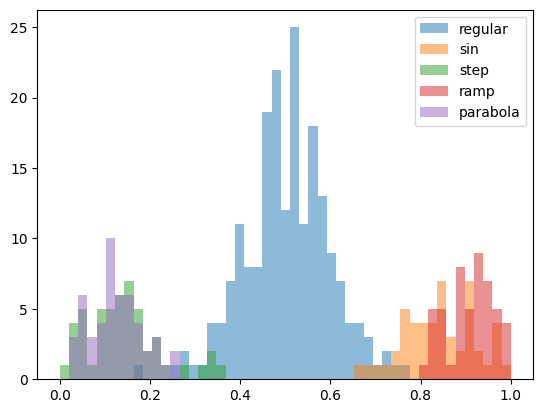

In [103]:
plot_error_distributions(df)

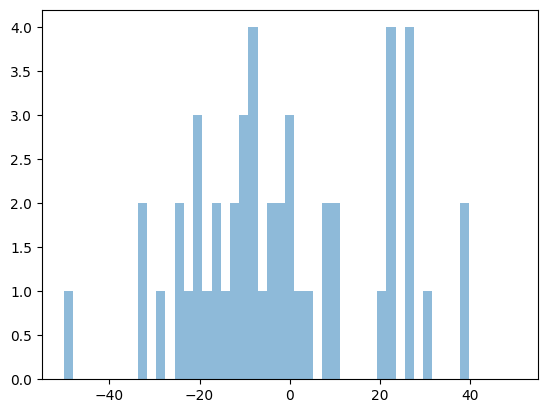

In [104]:
bins = np.linspace(-50, 50, 50)
_ = plt.hist(df[df['label']=='sin'].pattern_y, bins, alpha=0.5)

regular


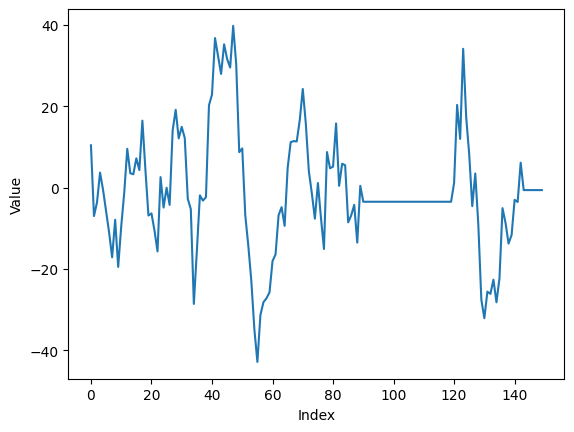

sin


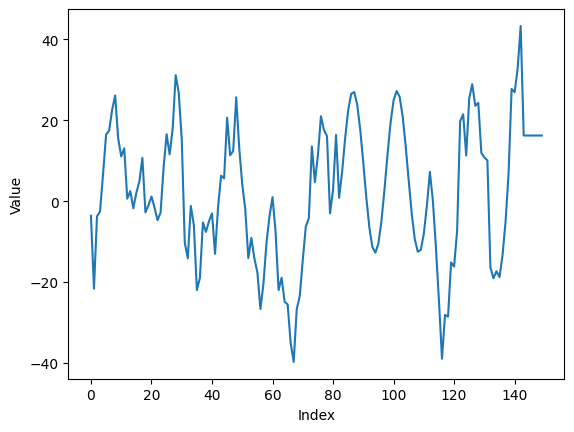

step


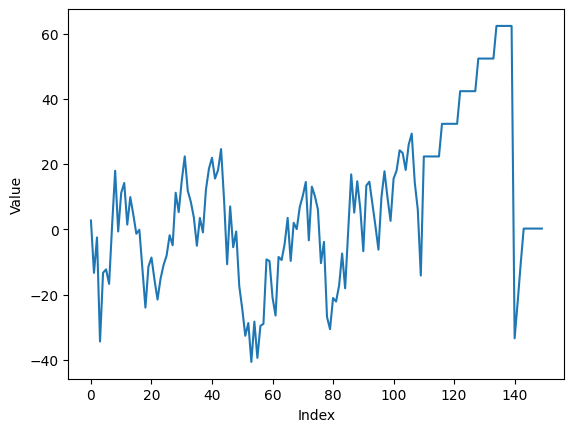

ramp


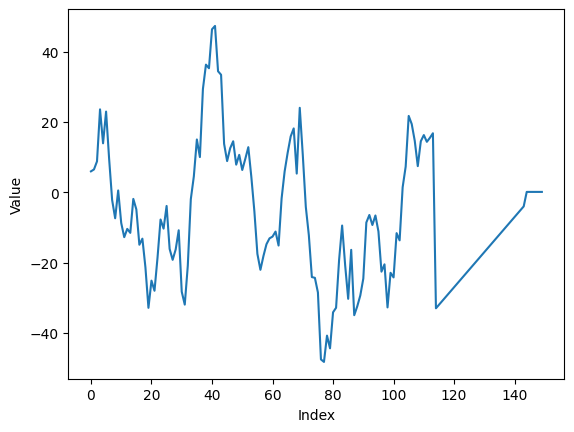

parabola


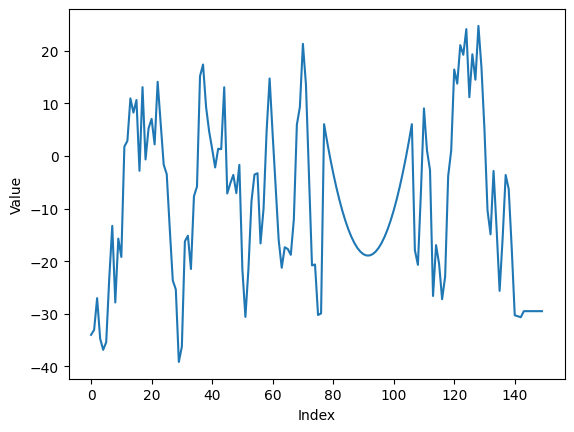

In [105]:
for lb in df['label'].value_counts().index:
    print(lb)
    plot_random_series_helper(df=df[df['label']==lb])

In [106]:
df.to_csv('./multipattern/MULTIPATTERN_v2.csv', index=False)